# SCIENCE

- Balmer decrement
- Star extincted spectra
- Stromgren radius

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
from astropy.io import fits

filter = ['Ha', 'Hb', 'g', 'r', 'i']
file_paths = {f: f'data/cleaned_calibrated/{f}_calibrated.fit' for f in filter}
filter_cmap = {'Ha': 'hot','Hb': 'magma','g': 'bone','r': 'hot','i': 'copper'}
image = {}
noise = {}

for f in filter:
    with fits.open(file_paths[f]) as hdul:
        image[f] = hdul[0].data
        header = hdul[0].header

with fits.open('data/cleaned_calibrated/Ha_calibrated.fit'):
    params_ra = [header.get(f'RA_A{i}') for i in range(3)]
    params_dec = [header.get(f'DEC_B{i}') for i in range(3)]

def xy_to_radec(x, y):
    """
    Transform grid of (x, y) to (RA, Dec) coordinates.
    """
    ra = params_ra[0] + params_ra[1] * x + params_ra[2] * y
    dec = params_dec[0] + params_dec[1] * x + params_dec[2] * y
    return ra, dec

def radec_to_xy(ra, dec):
    A = np.array([[params_ra[1], params_ra[2]],
                  [params_dec[1], params_dec[2]]])
    b = np.array([ra - params_ra[0], dec - params_dec[0]])
    # Solve the linear system A * [x, y] = b
    x, y = np.linalg.solve(A, b)
    return x, y

from astropy.io import fits

with fits.open("data/cleaned_calibrated/Ha_gaussian_filter.fit") as hdul:
   Ha_gauss = hdul[0].data
with fits.open("data/cleaned_calibrated/Ha_median_filter.fit") as hdul:
   Ha_median = hdul[0].data
with fits.open("data/cleaned_calibrated/Hb_gaussian_filter.fit") as hdul:
   Hb_gauss = hdul[0].data
with fits.open("data/cleaned_calibrated/Hb_median_filter.fit") as hdul:
   Hb_median = hdul[0].data

stars_astrometry = []

with fits.open("data/astrometry.fit") as hdul:
    if len(hdul) > 1:
        table_hdu = hdul[1]  

        if table_hdu.data.ndim == 1:
            table = np.stack(table_hdu.data)

        for row in table:
            stars_astrometry.append({'ra': row[0], 'dec': row[1], 'x': row[2], 'y': row[3]})

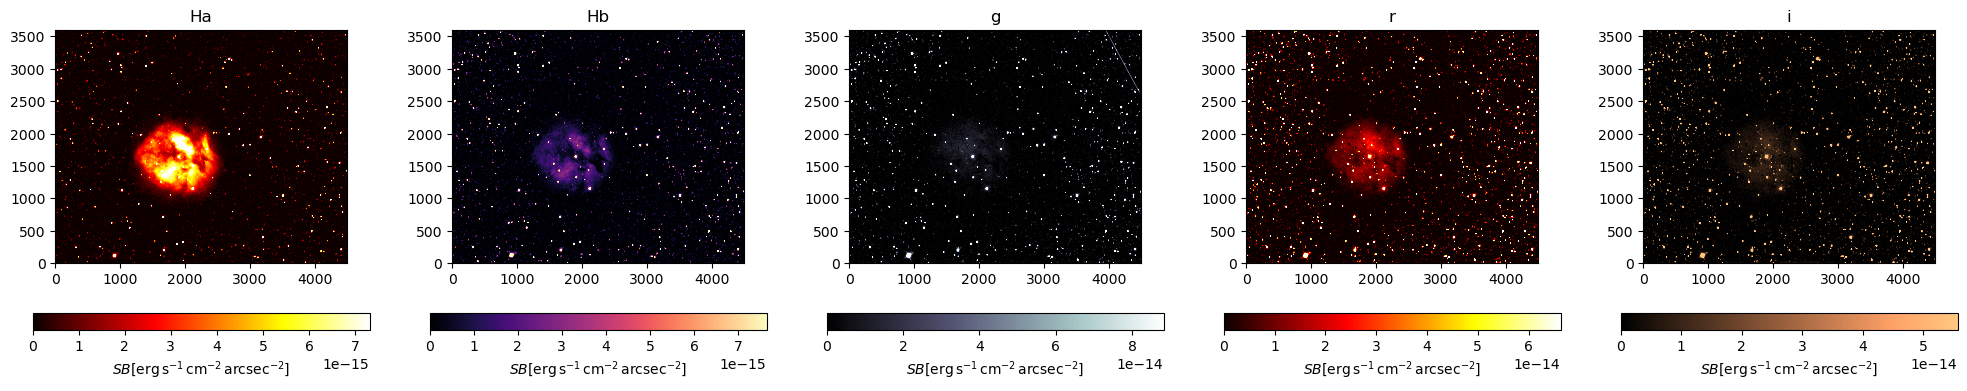

In [4]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, f in enumerate(filter):
    im = axes[i].imshow(image[f], clim=[0, np.quantile(image[f], 0.99)], cmap=filter_cmap[f], origin='lower')
    plt.colorbar(im, ax=axes[i], location='bottom', label="$SB  [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, arcsec^{-2}}]$") #fraction=0.0375, pad=0.1
    axes[i].set_title(f)

plt.tight_layout()
plt.show()


In the Hα (656.3 nm) filter, we observe the Balmer recombination transition (n=3 → n=2), a strong emission line tracing ionized hydrogen. The Hβ (486.1 nm) filter captures the n=4 → n=2 transition, another Balmer line that is fainter than Hα. The r-band includes Hα emission but at a lower signal-to-noise ratio (SNR) due to its broad bandwidth. Similarly, the g-band captures Hβ with reduced SNR, along with blue starlight. The i-band primarily detects starlight scattered from gas and dust within the nebula and possibly fainter recombination lines (n=4 → n=3).

# 1. Balmer Decrement and Extinction in the HII region

## Dust Extinction
It is well established that dust particles in the interstellar medium (ISM) absorb and scatter light from celestial objects in a highly selective manner, particularly affecting the UV wavelengths. Dust extinction is defined as $A_\lambda = 2.5 \log_{10}(F_{0,\lambda}/F_\lambda)$, where $F_{0,\lambda}$ and $F_\lambda$ are the intrinsic and observed fluxes. The optical depth is simply $\tau_\lambda = A_{\lambda}/1.086$.

Extinction is often expressed as function of the color excess (or reddening) $E(B-V) = (B-V)_{\text{observed}} - (B-V)_{\text{intrinsic}}$ and of the extinction curve $k(\lambda)$:

$$A_\lambda = k(\lambda)\,E(B-V)$$

Reddening is a measure of the column density of dust, while the extinction curve speaks of microphyisics of dust absorption. This last is often parametrized by the total-to-selective extinction ratio $R_V = A_V/(A_B-A_V) = A_V/E(B-V)$. Typical values in the Milky Way are $R_V\sim 3.1$, but they can range between 2 and 6 depending on the environmental conditions and dust composition. The amount of dust itself does not directly determine $R_V$, but denser environments (e.g., molecular clouds) are associated with grain growth (e.g., coagulation), which leads to larger average grain sizes and thus higher $R_V$​ values. 

- Diffuse ISM: Typical $R_V\sim 3.1$, associated with small grains. Steep extinction curves, small grains effective at absorbing blue/UV
- Dense Clouds: Larger grains dominate due to coagulation or icy mantles, leading to $R_V\sim 4−6$. Flatter extinction curves, large grains effective at absorbing red/IR. Very large grains would produce gray extinction with $R_V \rightarrow \infty$.
- Star-forming Regions: High radiation fields can destroy small grains, increasing $R_V$.
- Rayleigh scattering ($A_\lambda \propto \lambda^{−4}$) would produce very steep extinction with $R_V \sim 1.2$.

The two most popular extinction curves in literature are the Cardelli, Clayton, and Mathis (1989) (CCM89) and the Calzetti (2000). CCM89 is primarily applied to older stellar populations and general interstellar dust in galaxies like the Milky Way. It shows a characteristic decrease in extinction with increasing wavelength, with a steep rise in UV extinction. Calzetti law instead provides a model for the extinction of light in galaxies with ongoing star formation, like the Milky Way and other active star-forming galaxies. It shows more extinction in the ultraviolet (UV) range than in optical and infrared, which is typical for young stellar populations.


| **Feature**           | **Cardelli (CCM89)**                  | **Calzetti**                                |
|------------------------|---------------------------------------|---------------------------------------------|
| **Context**           | Milky Way extinction (ISM dust)       | Dust attenuation in starburst galaxies      |
| **Focus**             | Extinction of individual stars        | Attenuation of galaxy-wide light            |
| **2175 Å bump**       | Prominent                            | Weak or absent                              |
| **UV Behavior**       | Moderate UV extinction               | Stronger UV attenuation                     |
| **Geometry Considered**| Uniform dust-screen model            | Complex dust-star geometry                  |

Dust models we will consider are a mixture of carbonaceous grains and amorphous silicate grains. Carbonaceous grains are PAH (Polycyclic Aromatic Hydrocarbons)-like when small, and graphite-like when large (see Li & Draine 2001).


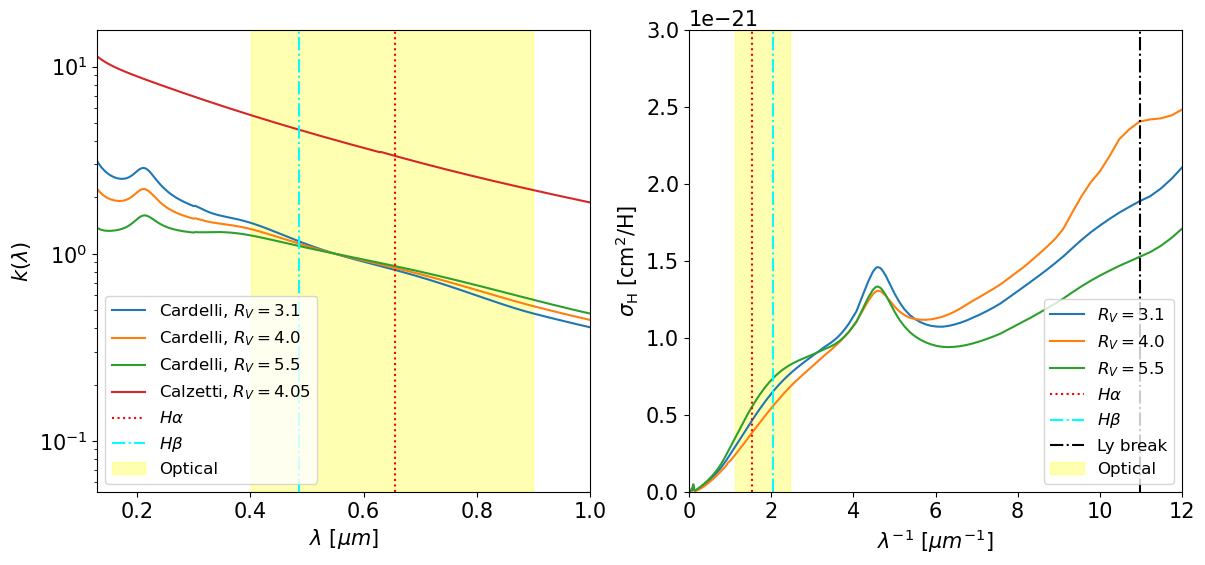

k(Ha) = 0.82 (Cardelli), 3.33 (Calzetti)
k(Hb) = 1.16 (Cardelli), 4.60 (Calzetti)


In [3]:
### === Dust extinction laws === ###

def ccm_extinction(wavelength, R_V=3.1):
    """
    Compute the CCM extinction curve k(λ) as a function of wavelength.
    
    Parameters:
        wavelength : float or numpy array
            Wavelength(s) in microns (µm).
        R_V : float
            Total-to-selective extinction ratio (default is 3.1).
    
    Returns:
        k_lambda : float or numpy array
            The extinction curve k(λ) = A(λ) / E(B-V).
    """
    wavelength = np.atleast_1d(wavelength)
    x = 1.0 / wavelength  # Convert wavelength to inverse microns
    k_lambda = np.zeros_like(x)

    # Infrared (x < 1.1 μm⁻¹)
    mask_ir = (x >= 0.3) & (x < 1.1)
    k_lambda[mask_ir] = 0.574 * x[mask_ir]**1.61 - 0.527 * x[mask_ir]**1.61 / R_V

    # Optical-NIR (1.1 ≤ x < 3.3 μm⁻¹)
    mask_opt = (x >= 1.1) & (x < 3.3)
    y = x - 1.82
    a_nuv = (
        1 + 0.17699 * y - 0.50447 * y**2 - 0.02427 * y**3 +
        0.72085 * y**4 + 0.01979 * y**5 - 0.77530 * y**6 + 0.32999 * y**7
    )
    b_nuv = (
        1.41338 * y + 2.28305 * y**2 + 1.07233 * y**3 - 5.38434 * y**4 -
        0.62251 * y**5 + 5.30260 * y**6 - 2.09002 * y**7
    )
    k_lambda[mask_opt] = a_nuv[mask_opt] + b_nuv[mask_opt] / R_V


    # UV and Far-UV (3.3 ≤ x ≤ 8 μm⁻¹)
    mask_fuv = (x >= 3.3) & (x <= 8.0)

    # Add Drude bump for x > 5.9
    F_a = np.where(x < 5.9, 0, -0.04473*(x-5.9)**2 - 0.009779*(x-5.9)**3)
    F_b = np.where(x < 5.9, 0, 0.2130*(x-5.9)**2 + 0.1207*(x-5.9)**3)
    
    a_fuv = (
        1.752 - 0.316 * x - 0.104 / ((x - 4.67)**2 + 0.341) + F_a
    )
    b_fuv = (
        -3.090 + 1.825 * x + 1.206 / ((x - 4.67)**2 + 0.341) + F_b
    )
    k_lambda[mask_fuv] = a_fuv[mask_fuv] + b_fuv[mask_fuv] / R_V

    return k_lambda[0] if wavelength.size == 1 else k_lambda


def calzetti_extinction(wavelength, R_V=4.05):
    """
    Compute the Calzetti attenuation curve k(λ) as a function of wavelength.
    
    Parameters:
        wavelength : float or numpy array
            Wavelength(s) in microns (µm).
        R_V : float
            Total-to-selective extinction ratio (default is 4.05).
    
    Returns:
        k_lambda : float or numpy array
            The attenuation curve k(λ) = A(λ) / E(B-V)_stars.
    """
    wavelength = np.atleast_1d(wavelength)
    k_lambda = np.zeros_like(wavelength)
    
    # UV to optical: 0.12 µm ≤ λ < 0.63 µm
    uv_opt_mask = (wavelength >= 0.12) & (wavelength < 0.63)
    lambda_uv_opt = wavelength[uv_opt_mask]
    k_lambda[uv_opt_mask] = (
        2.659 * (-2.156 + 1.509 / lambda_uv_opt - 0.198 / lambda_uv_opt**2 + 0.011 / lambda_uv_opt**3) + R_V
    )
    
    # Optical to NIR: 0.63 µm ≤ λ ≤ 2.2 µm
    opt_nir_mask = (wavelength >= 0.63) & (wavelength <= 2.2)
    lambda_opt_nir = wavelength[opt_nir_mask]
    k_lambda[opt_nir_mask] = (
        2.659 * (-1.857 + 1.040 / lambda_opt_nir) + R_V
    )

    return k_lambda[0] if wavelength.size == 1 else k_lambda

# Fitzpatrick DUST EXTINCTION 
# https://www.astro.princeton.edu/~draine/dust/extcurvs/kext_albedo_WD_MW_3.1_60_D03.all

import os
from scipy.interpolate import interp1d

dust_extinction = {}
R_V = ['3.1','4.0','5.5']

for i,filename in enumerate(os.listdir('dust_models')):
    if filename.endswith('.all'):  # Only process .all files
        file_path = os.path.join('dust_models', filename)

        # Initialize lists for lambda and C_ext/H
        lambda_values = []
        C_ext_H_values = []

        with open(file_path, "r") as file:
            lines = file.readlines()
            for line in lines[80:]:  # Start reading from the 80th line
                columns = line.split()
                if len(columns) >= 4:
                    try:
                        # Extract lambda and C_ext/H values
                        lambda_values.append(float(columns[0]))  
                        C_ext_H_values.append(float(columns[3]))  
                        
                    except ValueError:
                        continue
        
        # interpolate
        extinction_H_curve = interp1d(lambda_values,C_ext_H_values)
        
        # Add the data to the dictionary with the filename as key
        dust_extinction[R_V[i]] = {
            'lambda': lambda_values,
            'extinction_H_curve': extinction_H_curve
        }

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1,2,figsize=(14,6))

w = np.linspace(0.1, 3, 1000)
ax[0].plot(w, ccm_extinction(w), label='Cardelli, $R_V=3.1$')
ax[0].plot(w, ccm_extinction(w,R_V = 4.0), label='Cardelli, $R_V=4.0$')
ax[0].plot(w, ccm_extinction(w,R_V = 5.5), label='Cardelli, $R_V=5.5$')
ax[0].plot(w, calzetti_extinction(w), label='Calzetti, $R_V=4.05$')

ax[0].set_yscale("log")
ax[0].set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=15)
ax[0].set_ylabel(r"$k(\lambda)$", fontsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=15)  # Increase major ticks

wavelength_Ha = 656.281e-7    # Ha line (cm)
wavelength_Hb = 486.135e-7    # Hb line (cm)
Ly_break = 91.2e-7            # Lyman-break wavelength (cm)

ax[0].axvline(x=wavelength_Ha * 1e4, color='red', linestyle=':', label='$H\\alpha$')
ax[0].axvline(x=wavelength_Hb * 1e4, color='cyan', linestyle='-.', label='$H\\beta$')

ax[0].set_xlim(0.13,1)
y_min, y_max = ax[0].get_ylim()
ax[0].set_ylim(y_min,y_max)
ax[0].fill_between(w, y_min, y_max, where=(w >= 0.4) & (w <= 0.9),
                color='yellow', alpha=0.3, label="Optical")

ax[0].legend(fontsize=12)
#ax[0].set_title("Cardelli, Clayton, and Mathis (1989) Milky Way extinction law and \n Calzetti (2000)  Starburst Galaxies extinction law")

for rv in R_V:

    w = np.array(dust_extinction[rv]['lambda'])
    ax[1].plot(1/w, dust_extinction[rv]['extinction_H_curve'](w),label=f"$R_V = ${rv}")

ax[1].axvline(x = 1/(wavelength_Ha*1e4),c='red',linestyle=':',label='$H\\alpha$')
ax[1].axvline(x = 1/(wavelength_Hb*1e4),c='cyan',linestyle='-.',label='$H\\beta$')
ax[1].axvline(x = 1/(Ly_break*1e4), color='black', linestyle='-.', label='Ly break')

ax[1].fill_between(1/w, 0, 3e-21, where=(1/w <= 1/0.4) & (1/w >= 1/0.9),
                 color='yellow', alpha=0.3, label="Optical")

ax[1].set(xlim=(0, 12), ylim=(0, 30e-22))
ax[1].set_xlabel("$\\lambda^{-1}$ [$\\mu m^{-1}$]", fontsize=15)
ax[1].set_ylabel("$\\sigma_\\text{H}$ [$\\mathrm{cm^2 / H}$]", fontsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)  # Increase major ticks
ax[1].yaxis.get_offset_text().set_fontsize(15)
ax[1].legend(loc='lower right',fontsize=12)
#ax[1].set_title("Extinction, Scattering, and Absorption Properties \n Carbonaceous - Silicate Model for Interstellar Dust. Draine, 2003")


plt.show()

print(f"k(Ha) = {ccm_extinction(wavelength_Ha*1e4):.2f} (Cardelli), {calzetti_extinction(wavelength_Ha*1e4):.2f} (Calzetti)")
print(f"k(Hb) = {ccm_extinction(wavelength_Hb*1e4):.2f} (Cardelli), {calzetti_extinction(wavelength_Hb*1e4):.2f} (Calzetti)")


## Balmer Decrement

Dust extinction is defined by:

$$L_{obs}(\lambda) = L_{int}(\lambda)10^{-0.4A_\lambda} = L_{int}(\lambda)10^{-0.4k(\lambda)E(B-V)}$$

The relationship between the nebular emission-line color excess and the Balmer decrement is therefore given by:

$$E(B - V) = \frac{E(\mathrm{H}\beta - \mathrm{H}\alpha)}{k(\lambda_{\mathrm{H}\beta}) - k(\lambda_{\mathrm{H}\alpha})} = \frac{2.5}{k(\lambda_{\mathrm{H}\beta}) - k(\lambda_{\mathrm{H}\alpha})} \log_{10} \left[ \frac{(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{obs}}}{(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{int}}} \right]$$

where $(k(\lambda_{\mathrm{H}\beta}))$ and $(k(\lambda_{\mathrm{H}\alpha}))$ are the reddening curves evaluated at $H\beta$ and $H\alpha$ wavelengths, respectively. The factor $E(\mathrm{H}\beta - \mathrm{H}\alpha)$ is analogous to the color excess but defined for $H\beta$ and $H\alpha$ instead of the B and V bands. Then, $(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{obs}}$ is the observed Balmer decrement, and $(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{int}}$ is the intrinsic or unreddened Balmer decrement, which is calculated theoretically.

The intrinsic Balmer decrement remains roughly constant for typical gas conditions in star-forming galaxies (see Osterbrock 1989). In our analysis, we assume the value of $(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{int}} = 2.86$, corresponding to a temperature $T = 10^4 \, \mathrm{K}$ and an electron density $n_e = 10^2 \, \mathrm{cm}^{-3}$ for Case B recombination (Osterbrock 1989). This choice is standard for star-forming galaxies in the literature. Thus, the nebular color excess is given by the following equation:

$$E(B - V) = 1.97 \log_{10} \left( \frac{(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{obs}}}{2.86} \right)$$

### Case B Recombination:

***Lyman Continuum Photons are Reabsorbed***:
When a hydrogen atom recombines with an electron and transitions to the n=1 ground state, it emits a photon in the Lyman series (e.g., Lyman-α). Under Case B, these Lyman photons are absorbed and reprocessed within the gas, instead of escaping.
This reabsorption occurs because the gas is dense enough to be optically thick to ultraviolet photons in the Lyman series.

***Other Transitions are Optically Thin***:
Photons from transitions to levels n>1n (e.g., Hα from n=3→2) can escape the nebula without significant reabsorption.
This results in the prominence of Balmer, Paschen, and other series of hydrogen emission lines in the spectrum.


In [4]:
from astropy.io import fits
with fits.open('data/cleaned_calibrated/Ha_gaussian_filter_masked_stars.fit') as hdul:
    Ha_gauss = hdul[0].data
with fits.open('data/cleaned_calibrated/Hb_gaussian_filter_masked_stars.fit') as hdul:
    Hb_gauss = hdul[0].data

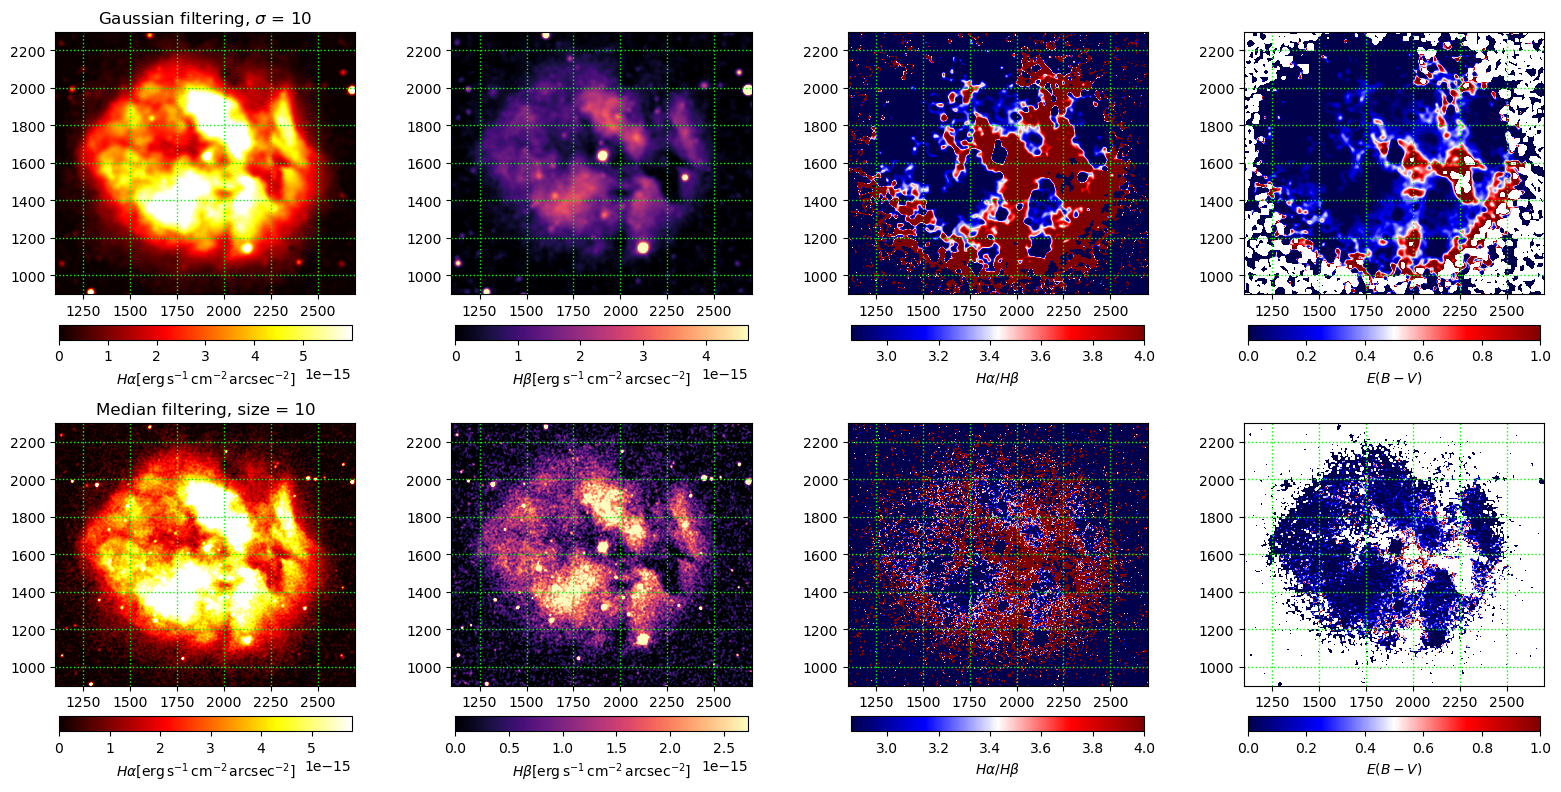

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

### === Gaussian filtering === ###

im0 = axes[0,0].imshow(Ha_gauss, origin='lower', clim=[0, np.quantile(Ha_gauss, 0.99)], cmap='hot')
fig.colorbar(im0, ax=axes[0,0], location='bottom', fraction=0.0475, pad=0.1, label='$H\\alpha [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, arcsec^{-2}}]$')

im1 = axes[0,1].imshow(Hb_gauss, clim=[0, np.quantile(Hb_gauss, 0.99)], origin='lower', cmap='magma')
fig.colorbar(im1, ax=axes[0,1], location='bottom', fraction=0.0475, pad=0.1, label='$H\\beta [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, arcsec^{-2}}]$')

im2 = axes[0,2].imshow(Ha_gauss / Hb_gauss, clim=[2.86,4], origin='lower', cmap='seismic')
fig.colorbar(im2, ax=axes[0,2], location='bottom', fraction=0.0475, pad=0.1, label='$H\\alpha/H\\beta$')

EBmV = 1.97 * np.log10(Ha_gauss / Hb_gauss / 2.86)

im3 = axes[0,3].imshow(EBmV, clim=[0,1], origin='lower', cmap='seismic') 
fig.colorbar(im3, ax=axes[0,3], location='bottom', fraction=0.0475, pad=0.1, label='$E(B-V)$')

axes[0,0].set_title("Gaussian filtering, $\sigma$ = 10")

### === Median filtering === ###

im0 = axes[1,0].imshow(Ha_median, origin='lower', clim=[0, np.quantile(Ha_median, 0.99)], cmap='hot')
fig.colorbar(im0, ax=axes[1,0], location='bottom', fraction=0.0475, pad=0.1, label='$H\\alpha [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, arcsec^{-2}}]$')

im1 = axes[1,1].imshow(Hb_median, clim=[0, np.quantile(Hb_median, 0.99)], origin='lower', cmap='magma')
fig.colorbar(im1, ax=axes[1,1], location='bottom', fraction=0.0475, pad=0.1, label='$H\\beta [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, arcsec^{-2}}]$')

im2 = axes[1,2].imshow(Ha_median / Hb_median, clim=[2.86,4], origin='lower', cmap='seismic')
fig.colorbar(im2, ax=axes[1,2], location='bottom', fraction=0.0475, pad=0.1, label='$H\\alpha/H\\beta$')

EBmV = 1.97 * np.log10(Ha_median / Hb_median / 2.86)

im3 = axes[1,3].imshow(EBmV, clim=[0,1], origin='lower', cmap='seismic') 
fig.colorbar(im3, ax=axes[1,3], location='bottom', fraction=0.0475, pad=0.1, label='$E(B-V)$')

axes[1,0].set_title("Median filtering, size = 10")

axes = axes.flatten()
for i in range(8):  # Updated to match 2 rows * 4 columns = 8 subplots
    axes[i].set_xlim(1100,2700)
    axes[i].set_ylim(900,2300)
    axes[i].set_aspect('equal')  # Ensures the grid cells are square
    axes[i].grid(visible=True, linestyle=':', linewidth=1, color='lime')

plt.tight_layout()
plt.show()


In [13]:
### === ERROR === ###

# after gaussian smoothing:
sigma_Ha = 1.04e-16
sigma_Hb = 1.45e-16

error_Balmer_ratio = np.sqrt((np.full_like(Ha_gauss, sigma_Ha)/Hb_gauss)**2 + (Ha_gauss * np.full_like(Hb_gauss, sigma_Hb)/Hb_gauss**2)**2) 
error_EBmV = np.full_like(Ha_gauss,1.97/np.log(10)) / (Ha_gauss/Hb_gauss) * error_Balmer_ratio  


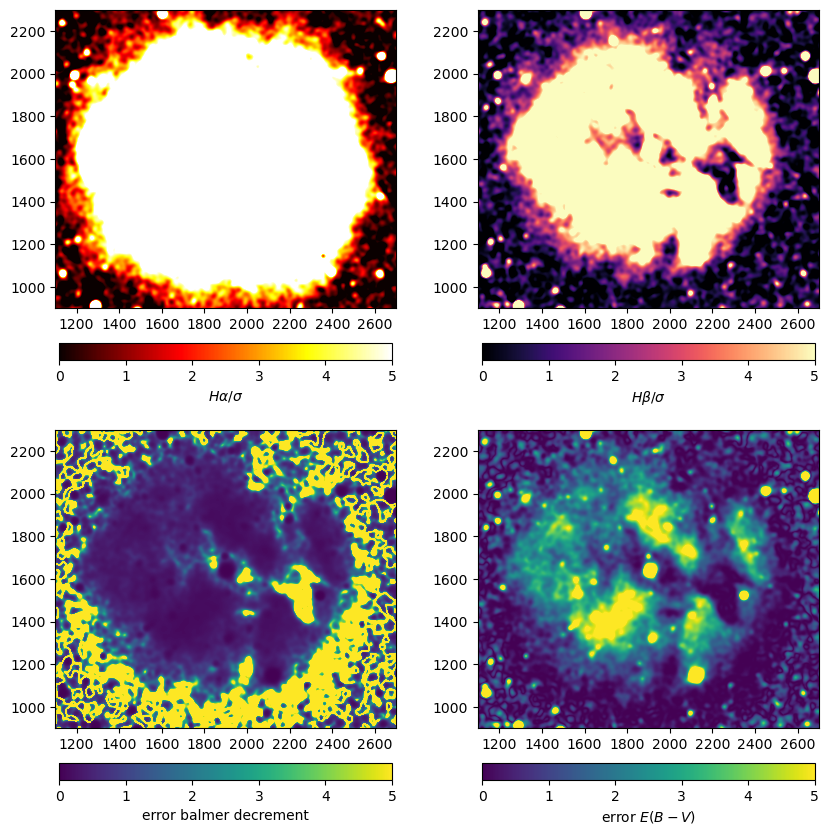

In [14]:
### === ERROR === ###

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

im0 = axes[0,0].imshow(Ha_gauss/sigma_Ha, origin='lower', clim=[0, 5], cmap='hot')
fig.colorbar(im0, ax=axes[0,0], location='bottom', fraction=0.0475, pad=0.1, label='$H\\alpha / \sigma$')

im1 = axes[0,1].imshow(Hb_gauss/sigma_Hb, clim=[0, 5], origin='lower', cmap='magma')
fig.colorbar(im1, ax=axes[0,1], location='bottom', fraction=0.0475, pad=0.1, label='$H\\beta / \sigma$')

error_Balmer_ratio = np.sqrt((np.full_like(Ha_gauss, sigma_Ha)/Hb_gauss)**2 + (Ha_gauss * np.full_like(Hb_gauss, sigma_Hb)/Hb_gauss**2)**2) 
error_EBmV = np.full_like(Ha_gauss,1.97/np.log(10)) / error_Balmer_ratio

im0 = axes[1,0].imshow(error_Balmer_ratio, origin='lower', clim=[0, 5], cmap='viridis')
fig.colorbar(im0, ax=axes[1,0], location='bottom', fraction=0.0475, pad=0.1, label='error balmer decrement')

im1 = axes[1,1].imshow(error_EBmV, clim=[0, 5], origin='lower', cmap='viridis')
fig.colorbar(im1, ax=axes[1,1], location='bottom', fraction=0.0475, pad=0.1, label='error $E(B-V)$')

axes = axes.flatten()
for i in range(4):  # Updated to match 2 rows * 4 columns = 8 subplots
    axes[i].set_xlim(1100,2700)
    axes[i].set_ylim(900,2300)



**Average Value**

In [15]:
# Central star is BD+46 3474 ( 	21 53 28.849152 	+47 15 59.78412   or    328.370205 	47.266607   J2000 ) 
# https://simbad.u-strasbg.fr/simbad/sim-coo?&Coord=328.375681513405d47.263674788998d&CooFrame=FK5&Radius=2&Radius.unit=arcmin
center_x, center_y = radec_to_xy(328.370134,47.266320) 

R_ext = 500 # pixels

from photutils.aperture import CircularAperture, aperture_photometry

aperture = CircularAperture((center_x, center_y), R_ext)
    
# Ha
phot_Ha = aperture_photometry(Ha_gauss, aperture, error = np.full(Ha_gauss.shape, 1.02e-16))
F_Ha = phot_Ha['aperture_sum'][0]
F_Ha_err = phot_Ha['aperture_sum_err'][0]   

# Hb
phot_Hb = aperture_photometry(Hb_gauss, aperture, error = np.full(Hb_gauss.shape, 1.45e-16))
F_Hb = phot_Hb['aperture_sum'][0]
F_Hb_err = phot_Hb['aperture_sum_err'][0]



In [18]:
print(f"Total flux in Ha filter is  {F_Ha:.2e} ± {F_Ha_err:.2e}" )

print(f"Total flux in Hb filter is  {F_Hb:.2e} ± {F_Hb_err:.2e}")

Balmer_mean = F_Ha / F_Hb
Balmer_mean_err = np.sqrt((F_Ha_err/F_Hb)**2 + (F_Hb_err*F_Ha/F_Hb**2)**2)

print(f"Average Ha/Hb decrement is  {Balmer_mean:.2f} ± {Balmer_mean_err:.2e}")

EBmV_mean = 1.97 * np.log10(Balmer_mean/2.86)
EBmV_mean_err = 1.97 * Balmer_mean_err /(np.log(10)*Balmer_mean/2.75)

print(f"Average E(B-V) is  {EBmV_mean:.2f} ± {EBmV_mean_err:.2e}")

Total flux in Ha filter is  3.17e-09 ± 9.04e-14
Total flux in Hb filter is  9.87e-10 ± 1.29e-13
Average Ha/Hb decrement is  3.21 ± 4.28e-04
Average E(B-V) is  0.10 ± 3.14e-04


# 2. Dust extinction on stars embedded in the Nebula using GAIA DR3 xp sampled spectra

**GAIA DR3 dataset**

Photometric and Spectrocopic data include:

- phot_g_mean_mag (E): mean magnitude in the GAIA G-band. This is the observed brightness of the star in the G-band, which GAIA measures through its photometric observations.

- bp_rp (E): difference between the magnitudes in the blue photometric band (BP) and the red photometric band (RP). This is also known as the color index. GAIA measures the star’s brightness in both the blue (BP) and red (RP) bands, and the difference between these values gives the color index, which is related to the star's temperature.

- phot_variable_flag (13A): A flag indicating whether the star is variable in brightness.

- non_single_star (I): A flag indicating whether the star is part of a binary or multiple star system. Determined through astrometric measurements, such as the star's motion or other evidence of companions.

- teff_gspphot (E): effective temperature of the star, derived from the star's color and luminosity using models of stellar atmospheres, typically from the GAIA photometric data and spectroscopic observations.

- logg_gspphot (E): surface gravity of the star, measured in log units (logarithmic scale). log(cm/s²). This is derived from the star’s luminosity, radius, and mass. It’s related to the star's stage in its lifecycle. 

- mh_gspphot (E): metallicity of the star, given in logarithmic units (dex). Metallicity is derived from the star’s spectrum and photometric measurements. It indicates the abundance of elements heavier than hydrogen and helium in the star.

- distance_gspphot (E): The distance to the star in pc, derived from the parallax measurements.

- azero_gspphot, ag_gspphot, ebpminrp_gspphot (E): extinction and reddening parameters that describe how the star’s light is affected by interstellar dust.

**GAIA Sampled XP Spectra** refer to the low-resolution prism-dispersed spectra obtained by the BP/RP (Blue Photometer / Red Photometer) spectrometers on board the GAIA space telescope. These spectra are part of the XP (Xp = eXtra Photometric) data, and they provide crucial spectral information across a broad wavelength range. BP (Blue Photometer): Covers the 330–680 nm range. RP (Red Photometer): Covers the 640–1050 nm range. These instruments disperse light at low resolution (~20–100), meaning they provide broad spectral energy distribution (SED) information rather than high-resolution spectral lines.

In [5]:
### === Open data catalogue === ###

with fits.open('data/GAIA_field.fits') as hdul:
    #print(hdul[1].header)
    columns = hdul[1].columns.names  
    GAIA_table = hdul[1].data

import pandas as pd
df = pd.DataFrame(GAIA_table)

from IPython.display import display, HTML
display(HTML("""
<style>
    .scrollable-table-container {
        overflow: auto; /* Enables scrolling */
        max-height: 500px; /* Set maximum height for vertical scrolling */
        border: 1px solid #ccc; /* Optional: Add border for clarity */
        padding: 5px;
    }
    .scrollable-table-container table {
        display: block; /* Ensures proper rendering for wide tables */
        white-space: nowrap; /* Prevent text wrapping in cells */
    }
</style>
<div class="scrollable-table-container">
""" + df.head().to_html(index=False) + "</div>"))


In [6]:
R_sun = 6.96e10                 # solar radius in cm
T_sun = 5778                    # K
L_sun = 3.83e33                 # erg/s
M_bol_sun = 4.74                # mag

parsec = 3.086e18               # cm


In [7]:
# download xp spectra
from astroquery.gaia import Gaia
retrieval_type = 'XP_SAMPLED'     # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'
data_structure = 'INDIVIDUAL'     # Options are: 'INDIVIDUAL' or 'RAW'
data_release   = 'Gaia DR3'       # Options are: 'Gaia DR3' (default), 'Gaia DR2'
datalink = Gaia.load_data(ids=GAIA_table['source_id'],data_release=data_release, retrieval_type=retrieval_type, data_structure=data_structure);

stars_gaia = []

for i in range(len(GAIA_table)): 

    source_id = GAIA_table[i]['source_id']  
    
    ra = GAIA_table[i]['ra']
    dec = GAIA_table[i]['dec']
    parallax = GAIA_table[i]['parallax']   # mas
    distance = 1/(parallax*1e-3)           # pc

    #distance = GAIA_table[i]['distance_gspphot']
    target_separation = GAIA_table[i]['target_separation (deg)'] 
    m_g = GAIA_table[i]['phot_g_mean_mag']
    color_index = GAIA_table[i]['bp_rp']
    EBmV = GAIA_table[i]['ebpminrp_gspphot']
    T_eff = GAIA_table[i]['teff_gspphot']

    M_g = m_g - 5*np.log10(distance) + 5
    BC_g = -0.1 + 0.06*(color_index)-0.0015*(color_index)**2
    M_bol = M_g + BC_g 
    L = 10**((M_bol_sun-M_bol)/2.5)   # in L_sun
    R = L**(1/2) * (T_sun/T_eff)**2   # in R_sun
    
    x,y = radec_to_xy(ra,dec)
        
    wavelengths = np.array(datalink[f"XP_SAMPLED-Gaia DR3 {GAIA_table['source_id'][i]}.xml"][0].to_table().as_array()['wavelength'])
    flux = np.array(datalink[f"XP_SAMPLED-Gaia DR3 {GAIA_table['source_id'][i]}.xml"][0].to_table().as_array()['flux'])
    flux_err = np.array(datalink[f"XP_SAMPLED-Gaia DR3 {GAIA_table['source_id'][i]}.xml"][0].to_table().as_array()['flux_error'])
    
    w = 10 * wavelengths  # wavelength in angstrom (GAIA original data gives wavelength in nm)
    flux = 1.e2 * flux  # specific flux in erg/s/cm2/angstrom (GAIA original data gives fluxes in W/m^2/nm)
    flux_err = 1.e2 * flux_err

    stars_gaia.append({'ra': ra, 'dec': dec, 'x': x, 'y': y, 
                       'parallax': parallax,
                       'distance': distance,
                       'target_separation_arcmin': target_separation * 60,
                       'T_eff': T_eff,
                       'L': L,
                       'R': R,
                       'EBmV': EBmV,
                        'spectra': [w,flux,flux_err]}
                     )

    

In [6]:
h = 6.62607015e-27                 # Planck's constant (erg·s)
c = 3.0e10                         # Speed of light (cm/s)
k_B = 1.380649e-16                 # Boltzmann's constant (erg/K)
sigma_Stefan_Boltzmann = 5.67e-5   # cgs
parsec = 3.086e18                  # cm

def intrinsic_flux(w,T_star,R_star,distance):
    """
    Assuming perfect black body of temperature T and emitting surface R 
    w in Armstrong
    returns intrinsic specific flux in erg/s/cm^2/angstrom 
    """
    w_cm = w * 1e-8 # wavelength in cm
    
    black_body = (2 * h * c**2) / (w_cm**5) * 1 / (np.exp((h * c) / (w_cm * k_B * T_star)) - 1)

    return 1e-8 * (R_star**2/distance**2) * np.pi * black_body


#########################################

def observed_flux(w,T_star,R_star,distance,
                  EBmV, Rv,
                  Cardelli = False,
                  Calzetti = False, 
                  Fitzpatrick = False, n_H = 1e2, R_cloud = 0.8*parsec):
    """
    Dust absorption
    w in Armstrong
    returns observed specific flux in erg/s/cm^2/angstrom 
    """
    w_micron = w*1e-4

    if Cardelli:
        return intrinsic_flux(w,T_star,R_star,distance) * np.exp(-ccm_extinction(w_micron,Rv) * EBmV)
        
    if Calzetti:
        return intrinsic_flux(w,T_star,R_star,distance) * np.exp(-calzetti_extinction(w_micron,Rv) * EBmV)


# Central star

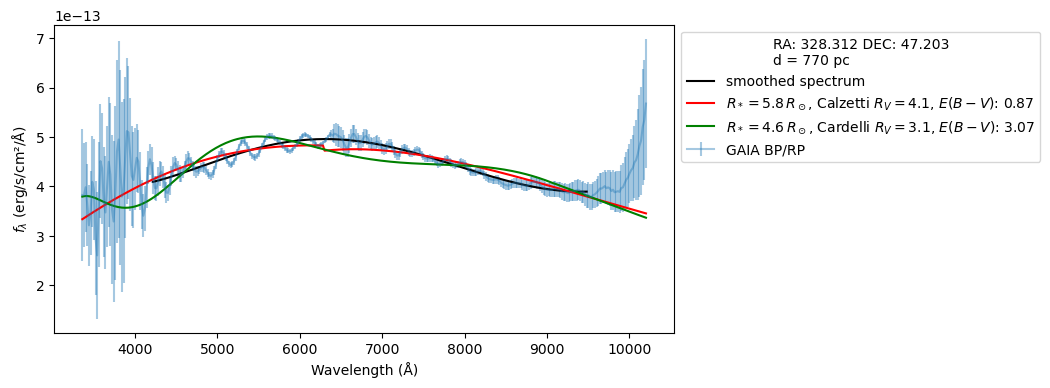

In [23]:
# Central star is BD+46 3474 ( 21 53 28.849152 +47 15 59.78412 or 328.370205 47.266607 J2000 ) 
# https://simbad.u-strasbg.fr/simbad/sim-coo?&Coord=328.375681513405d47.263674788998d&CooFrame=FK5&Radius=2&Radius.unit=arcmin

# From Rojas et al., 2014
T_eff = 32500                  # star surface temperature [K] 

R_star = 5.2 * R_sun            # star radius 

distance = 770 * parsec

w = stars_gaia[0]['spectra'][0]
flux = stars_gaia[0]['spectra'][1]
flux_err = stars_gaia[0]['spectra'][2]

fig,ax = plt.subplots(figsize=(8,4))

plt.errorbar(w,flux,flux_err,alpha=0.4,label='GAIA BP/RP')
plt.ylabel('$f_\lambda$ (erg/s/cm²/Å)', fontsize=10)
plt.xlabel("Wavelength (Å)", fontsize=10)

from numpy.polynomial.polynomial import Polynomial
# Fit a polynomial of degree 5
degree = 5
w_ = w[(w > 4200) & (w < 9500)]
flux_ = flux[(w > 4200) & (w < 9500)]
coeffs = np.polyfit(w_,flux_, degree)
poly = np.poly1d(coeffs)
smoothed_spectrum = poly(w_)
plt.plot(w_,smoothed_spectrum,c='black',alpha=1,label='smoothed spectrum')


from scipy.optimize import curve_fit

## Calzetti ##

p0 = [5*R_sun,0.5]  # Initial guess for E(B-V)
popt, pcov = curve_fit(
    lambda w,R_star, EBmV: observed_flux(w, T_eff, R_star, distance, EBmV, Rv=4.1, Calzetti = True),
    w_, smoothed_spectrum, p0=p0
)
optimized_R_star, optimized_EBmV = popt

fitted_flux = observed_flux(w,T_eff,optimized_R_star,distance, EBmV=optimized_EBmV, Rv=4.1, Calzetti = True)
plt.plot(w, fitted_flux, label=f"$R_* = {optimized_R_star/R_sun:.1f} \, R_\odot$, Calzetti $R_V = 4.1$, $E(B-V)$: {optimized_EBmV:.2f}", color='red')


## Cardelli #

p0 = [5*R_sun,0.5]  
popt, pcov = curve_fit(
    lambda w, R_star, EBmV: observed_flux(w, T_eff, R_star, distance, EBmV, Rv=3.1, Cardelli = True),
    w_, smoothed_spectrum, p0=p0
)
optimized_R_star, optimized_EBmV =  popt

fitted_flux = observed_flux(w,T_eff,optimized_R_star,distance, EBmV=optimized_EBmV, Rv=3.1, Cardelli = True)
plt.plot(w, fitted_flux, label=f"$R_* = {optimized_R_star/R_sun:.1f} \, R_\odot$, Cardelli $R_V = 3.1$, $E(B-V)$: {optimized_EBmV:.2f}", color='green')

plt.legend(fontsize=10,loc='upper left',bbox_to_anchor=(1, 1),title=f"RA: {star['ra']:.3f} DEC: {star['dec']:.3f}\nd = {distance/parsec:.0f} pc")


plt.show()


# Other stars


In [13]:
stars_behind_nebula = [star for star in stars_gaia if star['distance'] > 700 and star['target_separation_arcmin'] <5]
#print(len(stars_behind_nebula))

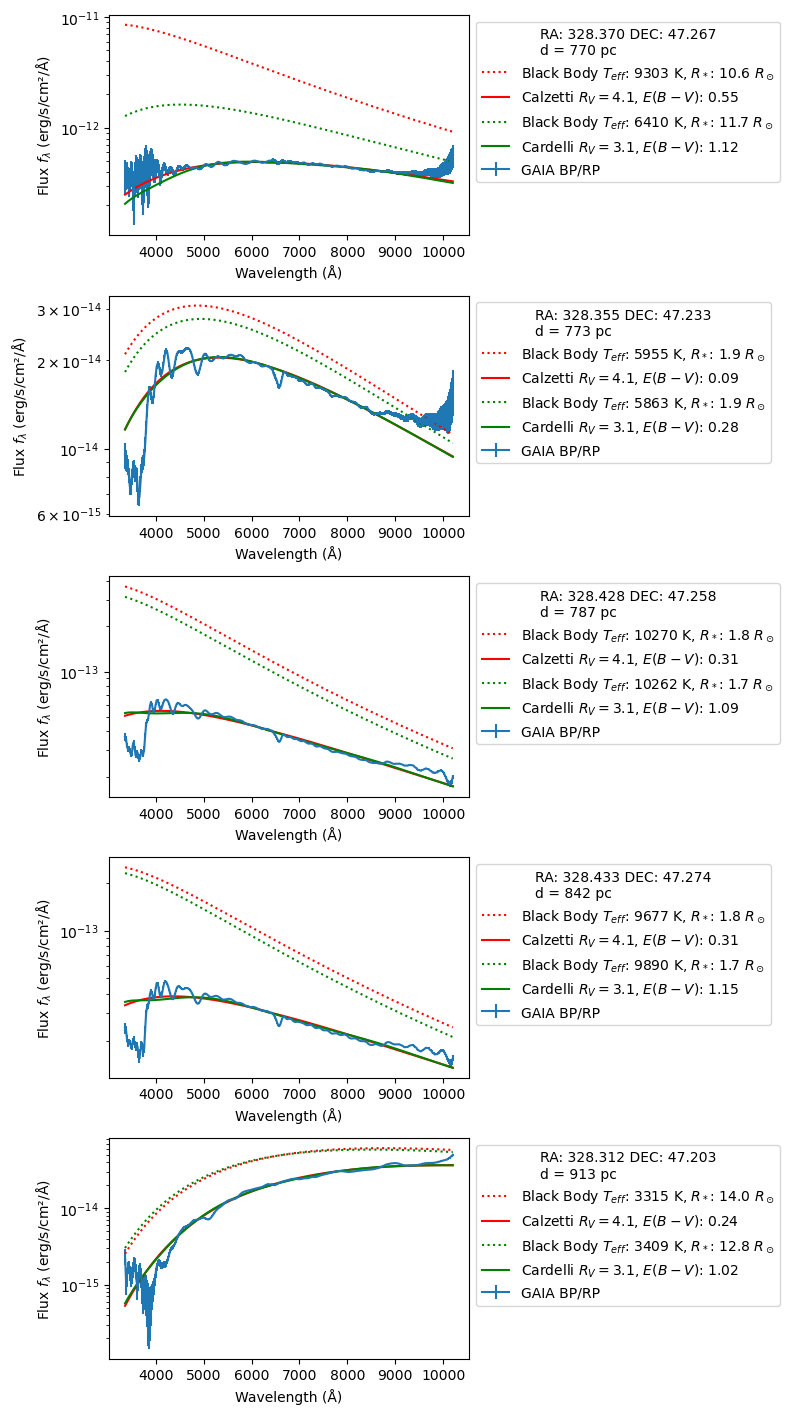

In [19]:
#from scipy.optimize import differential_evolution
from scipy.optimize import curve_fit

EBmV_Calzetti = []
EBmV_Cardelli = []


fig, axes = plt.subplots(5, 1, figsize=(8, 15))  
axes = axes.flatten()

for i,star in enumerate(stars_behind_nebula): 

    #EBmV_gaia = star['EBmV']
    #R_star = star['R'] * R_sun
    distance = star['distance'] * parsec   # cm
    
    w = star['spectra'][0]
    flux = star['spectra'][1]
    flux_err = star['spectra'][2]

    axes[i].errorbar(w,flux,flux_err,label='GAIA BP/RP')

    # Fit stellar radius and E(B-V) 

    ## Calzetti ##        
    
    p0 = [0.5,3*T_sun,R_sun]  # Initial guess for E(B-V) and R_star
    popt, pcov = curve_fit(
        lambda w, EBmV, T_eff, R_star: observed_flux(w, T_eff, R_star, distance, EBmV, Rv=4.1, Calzetti=True),
        w, flux, sigma=flux_err, p0=p0
    )
    optimized_EBmV, optimized_T, optimized_R = popt

    star['EBmV_fit Calzetti'] = optimized_EBmV

    flux_black_body = intrinsic_flux(w,optimized_T,optimized_R,distance)
    axes[i].plot(w, flux_black_body, color='red', linestyle=':',
                 label=f"Black Body $T_{{eff}}$: {optimized_T:.0f} K, $R_*$: {optimized_R/R_sun:.1f} $R_\odot$")

    fitted_flux = observed_flux(w,optimized_T,optimized_R,distance, EBmV=optimized_EBmV, Rv=4.1, Calzetti = True)
    axes[i].plot(w, fitted_flux, label=f"Calzetti $R_V = 4.1$, $E(B-V)$: {optimized_EBmV:.2f}", color='red')

    ## Cardelli ##
    
    p0 = [0.5,T_sun,R_sun]  # Initial guess for E(B-V)
    popt, pcov = curve_fit(
        lambda w, EBmV, T_eff, R_star: observed_flux(w, T_eff, R_star, distance, EBmV, Rv=3.1, Cardelli = True),
        w, flux, sigma=flux_err, p0=p0
    )
    optimized_EBmV, optimized_T, optimized_R = popt

    star['EBmV_fit Cardelli'] = optimized_EBmV

    flux_black_body = intrinsic_flux(w,optimized_T,optimized_R,distance)
    axes[i].plot(w, flux_black_body, color='green', linestyle=':',
                 label=f"Black Body $T_{{eff}}$: {optimized_T:.0f} K, $R_*$: {optimized_R/R_sun:.1f} $R_\odot$")

    fitted_flux = observed_flux(w,optimized_T,optimized_R,distance, EBmV=optimized_EBmV, Rv=3.1, Cardelli = True)
    axes[i].plot(w, fitted_flux, label=f"Cardelli $R_V = 3.1$, $E(B-V)$: {optimized_EBmV:.2f}", color='green')


    axes[i].set_yscale("log")
    axes[i].set_ylabel('$f_\\lambda$ (erg/s/cm²/Å)', fontsize=10)
    axes[i].set_xlabel('Wavelength (Å)', fontsize=10)

    #axes[i].text(0.15, 0.9,f"d = {distance/parsec:.0f} pc", fontsize=12, ha='center', transform=axes[i].transAxes)
    axes[i].legend(fontsize=10,loc='upper left',bbox_to_anchor=(1, 1),title=f"RA: {star['ra']:.3f} DEC: {star['dec']:.3f}\nd = {distance/parsec:.0f} pc")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
plt.show()



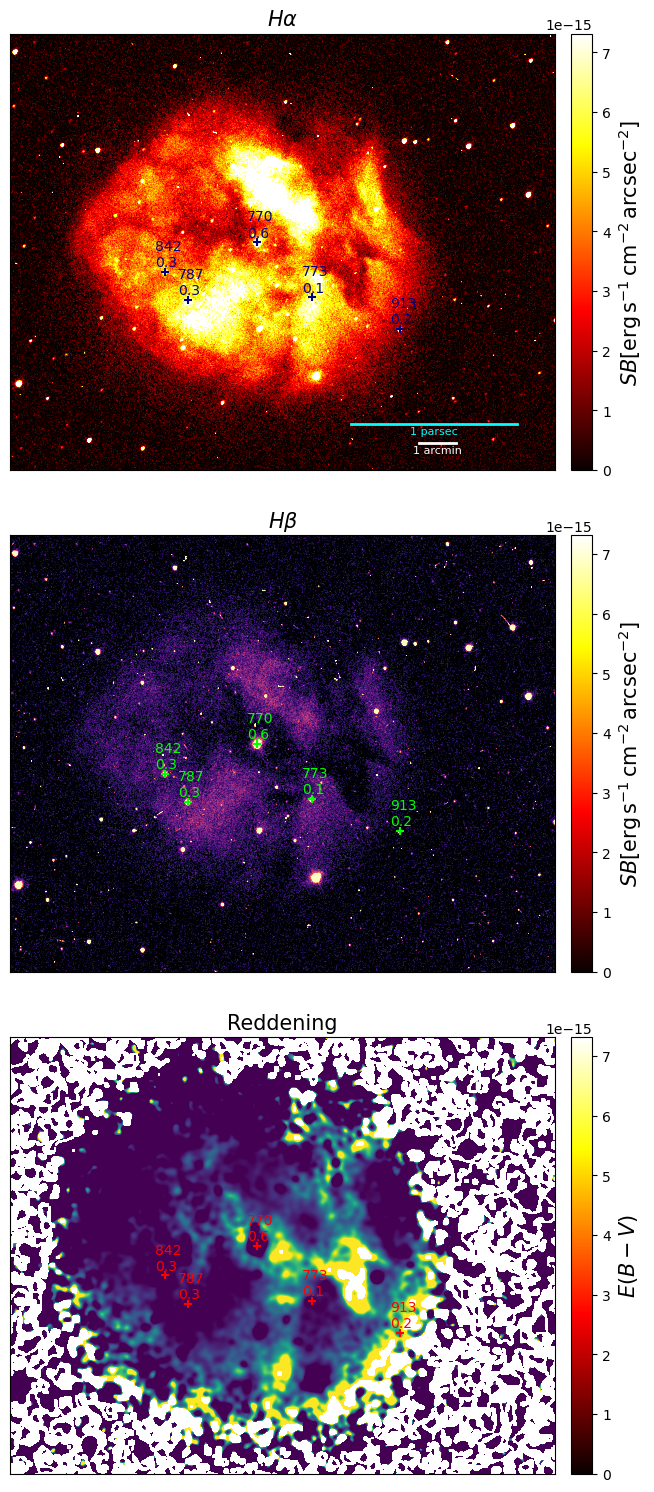

In [23]:
fig, axes = plt.subplots(3, 1, figsize=(9, 16))
axes = axes.flatten()

# Reduce spacing to make images larger  
fig.subplots_adjust(left=0.08, right=0.92, top=0.95, bottom=0.05, hspace=0.15)  

# Plot Hα flux
axes[0].set_title("$H\\alpha$",fontsize=15)
im0 = axes[0].imshow(image['Ha'],origin='lower',clim=[0, np.quantile(image['Ha'], 0.99)], cmap='hot')
cbar0 = fig.colorbar(im0, ax=axes[0], location='right', fraction=0.04, pad=0.02)
cbar0.set_label('$SB [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, arcsec^{-2}}]$', fontsize=15)  

axes[1].set_title("$H\\beta$",fontsize=15)
im1 = axes[1].imshow(image['Hb'],origin='lower',clim=[0, np.quantile(image['Hb'], 0.99)], cmap='magma')
cbar1 = fig.colorbar(im0, ax=axes[1], location='right', fraction=0.04, pad=0.02)
cbar1.set_label('$SB [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, arcsec^{-2}}]$', fontsize=15)  

# Plot E(B-V) map

EBmV = 1.97 * np.log10(Ha_gauss/Hb_gauss /2.86)

axes[2].set_title("Reddening",fontsize=15)
im2 = axes[2].imshow(EBmV, clim = [0,1], origin='lower', cmap='viridis') 
cbar2 = fig.colorbar(im0, ax=axes[2], location='right', fraction=0.04, pad=0.02)
cbar2.set_label('$E(B-V)$', fontsize=15)  

c = ['navy','lime','red']

for j in range(3):
    for star in stars_behind_nebula:
        ra = star['ra']
        dec = star['dec']
        x, y = radec_to_xy(ra,dec)
        axes[j].scatter(x,y,marker='+',c=c[j])
        d = star['distance']
        EBmV_Calzetti = star['EBmV_fit Calzetti']    
        EBmV_Cardelli = star['EBmV_fit Cardelli']   
        axes[j].text(x-35,y+20,f"{d:.0f}\n{EBmV_Calzetti:.1f}",c=c[j],fontsize=10)
    
    axes[j].grid(visible=True, linestyle=':', linewidth=1,c='lime')
    axes[j].set_xlim(1000,3000)
    axes[j].set_ylim(800,2400)
    axes[j].set_xticks([])  # Remove x-axis ticks
    axes[j].set_yticks([])  # Remove y-axis ticks
    axes[j].yaxis.get_offset_text().set_fontsize(15)

distance_pc = 770 
angular_size_pixel_TOBI_arcmin = 0.44 / 60 # arcmin per pixel

axes[0].plot([2500, 2500 + 1/angular_size_pixel_TOBI_arcmin], [900,900], color='white', lw=2)
axes[0].text(2500 + 1/angular_size_pixel_TOBI_arcmin / 2, 900 - 10, "1 arcmin", color='white',
        ha='center', va='top', fontsize=8)
    
L = (1/distance_pc) * 3437.75 / angular_size_pixel_TOBI_arcmin
axes[0].plot([2250, 2250 + L], [970,970], color='cyan', lw=2)
axes[0].text(2250 + L / 2, 970 - 10, "1 parsec", color='cyan', ha='center', va='top', fontsize=8)


plt.show()

# Strömgren sphere

**Ionization profile**
In 1937, Bengt Strömgren developed a simple model to describe the radial profile of the ionization fraction in HII regions. The central star emits $S_*$ ionizing photons per second ($h\nu > 13.6$ eV), and it is modeled as a perfect black body with surface temperature $T_*$ and radius $R_*$. The total ionizing photon emission rate is given by:

$$
S_* = 4\pi R_*^2 \int_0^{91.2} \frac{B(T_*, \lambda)}{hc/\lambda} \, d\lambda,
$$

where $B(T_*, \lambda)$ is the Planck function, and the integral is taken over wavelengths shorter than the Lyman limit (91.2 nm).

At a distance $r$ from the star, the photoionization equilibrium condition (neglecting collisional ionizations) is reached when the rate of ionizations equals the rate of recombinations. This condition is expressed as:

$$
\Gamma_\text{ion} n_H (1 - x) = x^2 n_H^2 \alpha_B,
$$

where $n_H$ is the uniform hydrogen number density, $x = n_{\text{HII}} / n_H$ is the ionized fraction, $\alpha_B = 2.59 \times 10^{-13} \, \text{cm}^3 \, \text{s}^{-1}$ at $T = 10^4$ K is the case B recombination coefficient for standard HII regions temperature (Osterbrock, 1989).

The photoionization rate is given by:

$$
\Gamma_\text{ion}(r) = \frac{S_*}{4 \pi r^2} e^{-\tau(r)} \cdot \sigma_H,
$$

where we assume spherical symmetry, $\sigma_H = 6.3 \times 10^{-18} \, \text{cm}^2$ is the hydrogen ionization cross section, and $\tau(r)$ is the optical depth, accounting for photon loss due to absorption within radius $r$.

Strömgren's original treatment did not include dust, but dust can be easily incorporated. The total optical depth $\tau(r)$ becomes:

$$
\tau(r) = \tau_H + \tau_\text{dust} = \int_0^r x(r) n_H \sigma_H \, dr' + \int_0^r n_H \tilde{\sigma}_{d,_H} \, dr',
$$

The effective dust cross section per hydrogen atom, $\sigma_{d,H}$ is a weighted average of the specific cross section per hydrogen atom, $\sigma_{\lambda,H}$, integrated over all wavelengths shorter than the Lyman break:

$$
\tilde{\sigma}_{d,H} = \frac{\int_0^{91.2} B(\lambda) \, \sigma_{d,H}(\lambda) \, d\lambda}{\int_0^{91.2} B(\lambda) \, d\lambda}.
$$

Finally, the stratification of the ionized hydrogen fraction is obtained by solving the equation numerically (and recursively):

$$
\frac{S_*}{4 \pi r^2} e^{-\left[ \int_0^r x(r) n_H \sigma_H \, dr' + \int_0^r n_H \tilde{\sigma}_{d,H} \, dr' \right]} n_H (1 - x(r)) \sigma_H = x(r)^2 n_H^2 \alpha_B.
$$

**Strömgren radius**

The transition from $x = 1$ (fully ionized) to $x = 0$ (fully neutral) is very steep. To approximate the ionization profile, we use a step function and define the **Strömgren radius** as the radius where hydrogen transitions from fully ionized to fully neutral.

This transition occurs when the rate of photoionizations equals the rate of recombinations, which can be expressed as:

$$S_* = \int_0^{R_S} \alpha_B n_{_{HII}}^2 \, 4 \pi r^2 \, dr$$

Assuming a uniform hydrogen density $n_{_H} = n_{_{HII}} $, this simplifies to:

$$R_S = \left(\frac{3S_*}{4\pi \alpha_B n_{_H}^2}\right)^{1/3}$$

It is straightforward to correct for dust: dust reduces the number of ionizing photons by absorbing a fraction of the radiation. This introduces an additional term to the ionization balance equation: 

$$S_*=\int_0^{R_S}\beta_2 n_p^2 4\pi r^2 dr + \int_0^{R_S} \Gamma_\text{ph}(r) n_\text{dust} 4\pi r^2dr$$

where $\Gamma_\text{dust}(r)$ is the rate of absorption by dust, $[\Gamma_\text{dust}] = \text{s}^{-1}$. It can be expressed as a function of the flux of ionizing photons and of the dust effective cross section: 

$$\Gamma_\text{ph}(r) = \frac{S_*}{4\pi r^2}e^{-\tilde{\sigma}_{d,_H}\,n_{_H}\,r}$$

Integrating:

$$S_* = \beta_2n_H^2 \tfrac{4\pi}{3}\,R_S^3 + S_*\left(1-e^{-\tilde{\sigma}_{d,_H}n_{_H}R_S}  \right)$$ 

The ultimate effect of dust is to reduce the number of ionizing photons of a factor $e^{-\tau_d} = e^{-\tilde{k}E(B-V)/1.086}$. In terms of reddening $E(B-V)$ and of the effective $k$ (averaged over all wavelenghts shorter than the Lyman break):

$$S_*e^{-\tilde{k}E(B-V)/1.086} = \alpha_B\,n_{_H}^2 \tfrac{4\pi}{3}R_S^3$$ 


References:


https://en.wikipedia.org/wiki/Str%C3%B6mgren_sphere

https://www.astroscu.unam.mx/rmaa/RMxAA..51-2/PDF/RMxAA..51-2_aragaV.pdf

https://articles.adsabs.harvard.edu/pdf/1972ApJ...177L..69P

https://iopscience.iop.org/article/10.1086/317718/pdf

https://arxiv.org/pdf/1705.00269


# Extract the surface brightness radial profile to determine the cloud radius

Due to the clear non-uniformity oh the nebula the radial profile is extracted with circular apertures on many rays. Circular annuli are defined as well.

In [4]:
### === CIRCULAR ANNULI === ### 

# Central star is BD+46 3474 ( 	21 53 28.849152 	+47 15 59.78412   or    328.370205 	47.266607   J2000 ) 
# https://simbad.u-strasbg.fr/simbad/sim-coo?&Coord=328.375681513405d47.263674788998d&CooFrame=FK5&Radius=2&Radius.unit=arcmin
center_x, center_y = radec_to_xy(328.370134,47.266320) 

# Define the inner and outer radii for the circular annuli such that each annulus contains the same number of pixels (50000)
num_annuli = 40
N = 50000
R_int_pixel = [0.1]
R_ext_pixel = []

for i in range(num_annuli):
    r_ext = np.sqrt(N/np.pi + R_int_pixel[-1]**2)  # Use the previous outer radius to define the next outer radius
    R_ext_pixel.append(r_ext)
    R_int_pixel.append(r_ext)

# Generate the list of annuli radii as tuples of inner and outer radii (PIXEL SPACE)
annuli_radii = [(R_int_pixel[i], R_ext_pixel[i]) for i in range(num_annuli)]  

# Average surface brightness in each annulus
from photutils.aperture import CircularAnnulus, aperture_photometry

average_surface_brightness_Ha_annulus = []
average_surface_brightness_Hb_annulus = []

for inner_r, outer_r in annuli_radii:

    annulus = CircularAnnulus((center_x, center_y), r_in=inner_r, r_out=outer_r)

    # Ha
    phot = aperture_photometry(Ha_gauss, annulus, error = np.full(Ha_gauss.shape, 1.04e-16))
    I_Ha = phot['aperture_sum'][0]
    Ha_err = phot['aperture_sum_err'][0]              
    average_surface_brightness_Ha_annulus.append([I_Ha / N, Ha_err / N])

    # Hb
    phot = aperture_photometry(Hb_gauss, annulus, error = np.full(Hb_gauss.shape, 1.45e-16))
    I_Hb = phot['aperture_sum'][0]
    Hb_err = phot['aperture_sum_err'][0]
    average_surface_brightness_Hb_annulus.append([I_Hb / N, Hb_err / N])

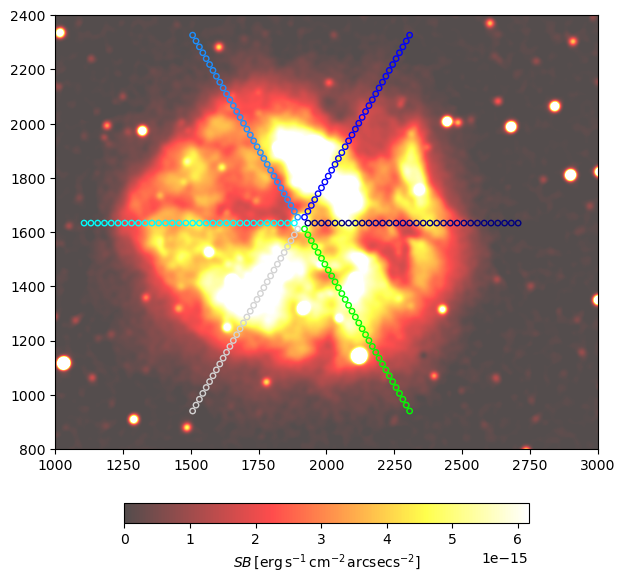

In [5]:
### === RADIAL DIRECTIONS === ### 

fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(Ha_gauss, cmap=filter_cmap['Ha'],clim=[0, np.quantile(Ha_gauss, 0.99)],origin='lower',alpha=0.7)
fig.colorbar(im,ax=ax,location='bottom', fraction=0.0375, pad=0.1, label="$SB \, [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, arcsecs^{-2}}]$")

center_x, center_y = radec_to_xy(328.370134,47.266320) 
ax.set_xlim(1000,3000)
ax.set_ylim(800,2400)

theta = [np.pi/3 * i for i in range(6)]
lines_Ha = []
lines_Hb = []
colors = ['navy', 'blue', 'dodgerblue', 'cyan', 'lightgrey', 'lime'] #, 'mediumseagreen', 'darkgreen']
radius = 10 
step = 25
r_array = np.array([step*i for i in range(1,33)])

from photutils.aperture import CircularAperture,aperture_photometry
from matplotlib.patches import Circle

for j,t in enumerate(theta):
    
    average_surface_brightness_Ha = []    
    average_surface_brightness_Hb = []


    v = np.array([np.cos(t),np.sin(t)])
    for i in range(1,33):

        c_x,c_y = center_x + v[0]*step*i, center_y + v[1]*step*i
        circle = CircularAperture((c_x,c_y), r = radius)
        area = np.pi*radius**2
        
        # Ha
        phot = aperture_photometry(Ha_gauss, circle, error = np.full(Ha_gauss.shape, 1.04e-16))
        I_Ha = phot['aperture_sum'][0]
        Ha_err = phot['aperture_sum_err'][0]               # = sqrt(N) * sigma
        average_surface_brightness_Ha.append([I_Ha / area, Ha_err / area])
    
        # Hb
        phot = aperture_photometry(Hb_gauss, circle, error = np.full(Hb_gauss.shape, 1.45e-16))
        I_Hb = phot['aperture_sum'][0]
        Hb_err = phot['aperture_sum_err'][0]
        average_surface_brightness_Hb.append([I_Hb / area, Hb_err / area])

        circle = Circle((c_x,c_y), radius=radius, fill=False, linewidth=1, linestyle='-',color=colors[j])
        ax.add_patch(circle)

    lines_Ha.append(average_surface_brightness_Ha)
    lines_Hb.append(average_surface_brightness_Hb)

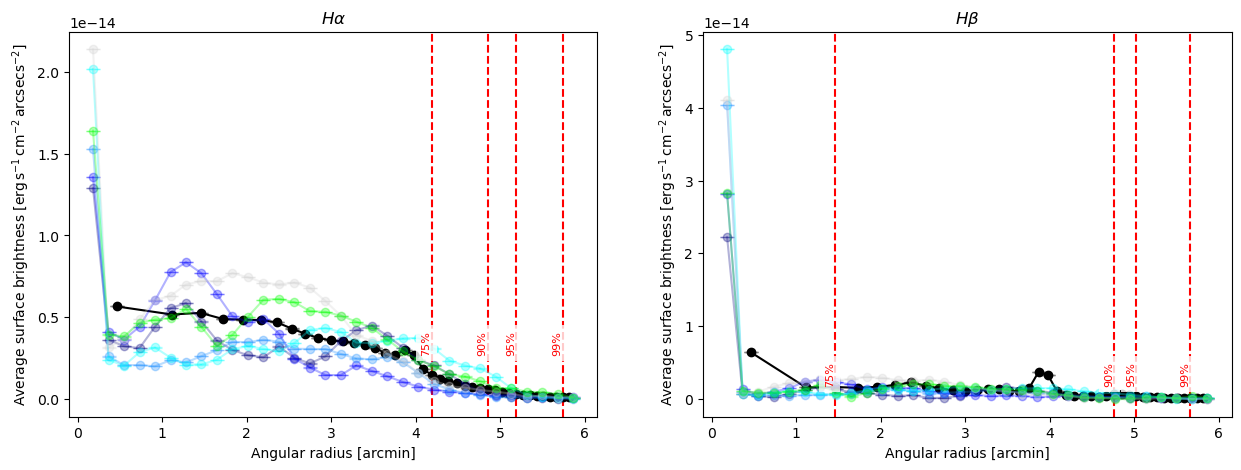

In [6]:
### === PLOT PROFILES === ###

angular_size_pixel_TOBI_arcmin = 0.44 / 60 # arcmin per pixel
theta_r = np.array([(inner_r + outer_r) / 2 for inner_r, outer_r in annuli_radii]) * angular_size_pixel_TOBI_arcmin

fig, ax = plt.subplots(1,2,figsize=(15,5))


ax[0].set(title = "$H\\alpha$", xlabel = "Angular radius [arcmin]", ylabel = "Average surface brightness $[\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, arcsecs^{-2}}]$")

I_Ha = [ph[0] for ph in average_surface_brightness_Ha_annulus]
err_Ha = [ph[1] for ph in average_surface_brightness_Ha_annulus]

ax[0].errorbar(theta_r, I_Ha, yerr=err_Ha, fmt='o', color='black', ecolor='grey', capsize=5, linestyle='-')

x = I_Ha/(max(I_Ha))
R_75 = theta_r[np.argmin(np.abs(x - (1-0.75)))]
R_90 = theta_r[np.argmin(np.abs(x - (1-0.90)))]
R_95 = theta_r[np.argmin(np.abs(x - (1-0.95)))]
R_99 = theta_r[np.argmin(np.abs(x - (1-0.99)))]

for r, label in zip([R_75, R_90, R_95, R_99], ['75', '90', '95', '99']):
    ax[0].axvline(r, color='red', linestyle='--', linewidth=1.5)
    ax[0].text(r, max(I_Ha) * 0.6, f"{label}%", rotation=90, 
               color='red', fontsize=8, va='center', ha='right', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))


ax[1].set(title = "$H\\beta$", xlabel = "Angular radius [arcmin]", ylabel = "Average surface brightness $[\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, arcsecs^{-2}}]$")

I_Hb = [ph[0] for ph in average_surface_brightness_Hb_annulus]
err_Hb = [ph[1] for ph in average_surface_brightness_Hb_annulus]

ax[1].errorbar(theta_r, I_Hb, yerr=err_Hb, fmt='o', color='black', ecolor='grey', capsize=5, linestyle='-')

x = I_Hb/(max(I_Hb))
R_75_ = theta_r[np.argmin(np.abs(x - (1-0.75)))]
R_90_ = theta_r[np.argmin(np.abs(x - (1-0.90)))]
R_95_ = theta_r[np.argmin(np.abs(x - (1-0.95)))]
R_99_ = theta_r[np.argmin(np.abs(x - (1-0.99)))]

for r, label in zip([R_75_, R_90_, R_95_, R_99_], ['75', '90', '95', '99']):
    ax[1].axvline(r, color='red', linestyle='--', linewidth=1.5)
    ax[1].text(r, max(I_Ha) * 0.6, f"{label}%", rotation=90, 
               color='red', fontsize=8, va='center', ha='right', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

##

theta_r_ = r_array * angular_size_pixel_TOBI_arcmin 

for i in range(len(lines_Ha)):
    
    ax[0].errorbar(theta_r_, [ph[0] for ph in lines_Ha[i]], yerr=[ph[1] for ph in lines_Ha[i]], fmt='o', color=colors[i], 
             ecolor=colors[i], capsize=5,linestyle='-',alpha=0.3)
    ax[1].errorbar(theta_r_, [ph[0] for ph in lines_Hb[i]], yerr=[ph[1] for ph in lines_Hb[i]], fmt='o', color=colors[i], 
             ecolor=colors[i], capsize=5,linestyle='-',alpha=0.3)


plt.show()

# Compute Strömgren radius

In [25]:
### === Extimate star ionizing photon rate === ###

T_star = 32500                  # star surface temperature [K] 
R_sun = 6.96e10                 # solar radius in cm
R_star = 5.8 * R_sun            # star radius 

h = 6.62607015e-27              # Planck's constant (erg·s)
c = 3.0e10                      # Speed of light (cm/s)
k_B = 1.380649e-16              # Boltzmann's constant (erg/K)
Ly_break = 91.2e-7              # Lyman-break wavelength (cm)

# Black body function in CGS units
def black_body(w):
    return (2 * h * c**2) / (w**5) * 1 / (np.exp((h * c) / (w * k_B * T_star)) - 1)

# Integration over wavelength to find the total number of ionizing photons emitted over 4 pi by the star
import numpy as np
from scipy.integrate import quad
photons_area_time_sterad, _ = quad(lambda w: black_body(w) / (h * c / w), 0, Ly_break)

S = 4 * np.pi * R_star**2 * np.pi * photons_area_time_sterad    # Ionizing photon rate 
print(f"Ionizing photon rate is: {S:.2e} s-1") 

Ionizing photon rate is: 1.22e+48 s-1


In [26]:
### === Extimate dust effective cross section === ###

import os
from scipy.integrate import quad
from scipy.interpolate import interp1d

dust_extinction = {}
R_V = ['3.1','4.0','5.5']

for i,filename in enumerate(os.listdir('dust_models')):
    if filename.endswith('.all'):
        file_path = os.path.join('dust_models', filename)

        lambda_values = []
        C_ext_H_values = []

        with open(file_path, "r") as file:
            lines = file.readlines()
            for line in lines[80:]: 
                columns = line.split()
                if len(columns) >= 4:
                    try:
                        lambda_values.append(float(columns[0]))  
                        C_ext_H_values.append(float(columns[3]))  
                        
                    except ValueError:
                        continue
        
        # interpolate
        extinction_H_curve = interp1d(lambda_values,C_ext_H_values, kind='linear', fill_value="extrapolate")

        dust_extinction[R_V[i]] = {'lambda': lambda_values,'extinction_H_curve': extinction_H_curve}

# An effective dust cross section that encompasses all UV

for rv in R_V:
    numerator, _ = quad(lambda w: dust_extinction[rv]['extinction_H_curve'](w*1e4) * 4 * np.pi * R_star**2 * np.pi * black_body(w) / (h * c / w), 0, Ly_break)
    sigma_dust_H_eff = numerator / S

    print(f"Effective dust cross-section for Rv = {float(rv)} is: {sigma_dust_H_eff:.2e} cm^2/H") 

Effective dust cross-section for Rv = 3.1 is: 2.15e-21 cm^2/H
Effective dust cross-section for Rv = 4.0 is: 2.49e-21 cm^2/H
Effective dust cross-section for Rv = 5.5 is: 1.76e-21 cm^2/H


In [33]:
### === Extimate E(B-V) from dust optical depth === ###

sigma_dust_H_eff = 2.15e-21

# tau_UV = k_UV_eff E(B-V) = n_H sigma_UV_eff R_s
# tau_Ha = k_Ha E(B-V) = n_H sigma_Ha R_s
# k_UV_eff = k_Ha sigma_UV_eff/sigma_Ha 

# k(Ha) = 0.82 (Cardelli), 3.33 (Calzetti)
k_Ha = 0.82
wavelength_Ha = 656.281e-7    # Ha line (cm)
sigma_H_Ha = dust_extinction['5.5']['extinction_H_curve'](wavelength_Ha*1e4) 
k_eff = sigma_dust_H_eff/sigma_H_Ha * k_Ha

def trascendent_eq(R_S):
        # csi parameter regulates the amount of dust mixed with the hydrogen
        return S * np.exp(- csi * sigma_dust_H_eff * n_H * R_S) - alpha_B * n_H**2 * 4*np.pi/3 * R_S**3   
#R_S = optimize.root_scalar(trascendent_eq, bracket=[1e16, 3e19], method='brentq').root

def dusty_Stromgren_radius(EBmV):
        return (3 * S * np.exp(- k_eff * EBmV / 1.086) / (alpha_B * 4 * np.pi * n_H**2))**(1/3)

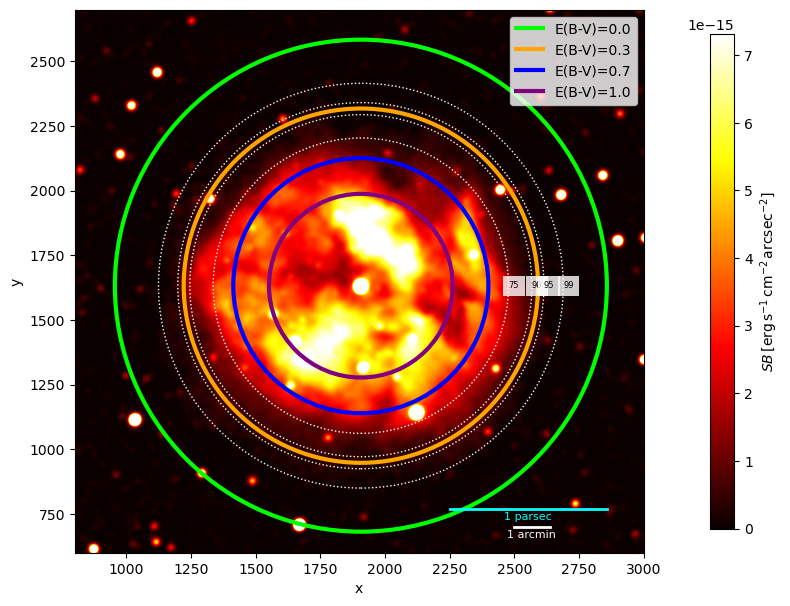

In [34]:
### === Find Stromgren radius === ###

parsec = 3.086e18               # cm
distance = 770 * parsec         # from GAIA parallax

T = 1e4
n_H = 1e2                       # Hydrogen number density typical for HII region [cm^-3]

wavelength_Ha = 656.281e-7      # Ha line (cm)
alpha_B = 2.6e-13               # Case B recombination coefficient cm^3 s^-1
parsec = 3.086e18               # cm


import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,8))


im = ax.imshow(Ha_gauss, clim=[0,np.quantile(image['Ha'], 0.99)], cmap=filter_cmap['Ha'] , origin='lower')
plt.colorbar(im, ax = ax, location='right', fraction=0.0375, pad=0.1, 
             label="$SB\\, [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, arcsec^{-2}}]$")

from matplotlib.patches import Circle
from matplotlib.lines import Line2D

center_x, center_y = radec_to_xy(328.370134,47.266320) 
angular_size_pixel_TOBI = 0.44 # arcsec per pixel

handles = []
colors = ['lime','orange','blue','purple']

for i,EBmV in enumerate(np.linspace(0,1,4)):
    
    R_S = dusty_Stromgren_radius(EBmV)
    theta_stromgen_arcsec = R_S / distance * 206265
    circle = Circle((center_x, center_y), radius=theta_stromgen_arcsec / angular_size_pixel_TOBI, 
                    fill=False, linewidth=3, linestyle='-', color = colors[i])
    ax.add_patch(circle)
    
    handles.append(Line2D([0], [0], lw=3, linestyle='-', color = colors[i],
                        label=f"E(B-V)={EBmV:.1f}"))

R_75_pix = R_75 / angular_size_pixel_TOBI_arcmin
R_90_pix = R_90 / angular_size_pixel_TOBI_arcmin
R_95_pix = R_95 / angular_size_pixel_TOBI_arcmin
R_99_pix = R_99 / angular_size_pixel_TOBI_arcmin

for R, label in zip([R_75_pix, R_90_pix, R_95_pix, R_99_pix], ['75', '90', '95', '99']):
    circle = Circle((center_x, center_y), radius=R, fill=False, linewidth=1, 
                    linestyle=':', color='white')
    ax.add_patch(circle)
    
    # Add text annotation near the edge of each circle
    ax.text(center_x + R, center_y, label, color='black', fontsize=6,
            va='center', ha='left', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

ax.set_xlim(800,3000)
ax.set_ylim(600,2700)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(handles=handles, loc='upper right')

ax.text(900,2600,f"$d = $ {distance/parsec:.0f} pc")

ax.plot([2500, 2500 + 1/angular_size_pixel_TOBI_arcmin], [700,700], color='white', lw=2)
ax.text(2500 + 1/angular_size_pixel_TOBI_arcmin / 2, 700 - 10, "1 arcmin", color='white',
        ha='center', va='top', fontsize=8)

L = (1*parsec/distance) * 3437.75 / angular_size_pixel_TOBI_arcmin
ax.plot([2250, 2250 + L], [770,770], color='cyan', lw=2)
ax.text(2250 + L / 2, 770 - 10, "1 parsec", color='cyan',
        ha='center', va='top', fontsize=8)


plt.tight_layout()  
plt.show()

# Radial profile of the ionized fraction


In [152]:
# nebula physical parameters

T = 1e4                         # temperature [K]
n_H = 1e2                       # Hydrogen number density typical for HII region [cm^-3]
sigma_H = 6.3e-18               # photoionization cross section [cm^2]

alpha_B = 2e-13 # * T**(-3/4)    # hydrogen recombination rate for n>=2 [cm^3 s^-1] 

In [153]:
# Root-finding function: for given r, founds correspondent x solving equation f_root(r=param,x) = 0
# To compute tau a x(r) function must be already defined. This function will be updated recursively
parsec = 3.086e18               # cm
r_in = 0.01 * parsec
def f_root(r, x, x_func):  
    if r > r_in:
        tau_r, _ = quad(lambda r_prime: ((1 - x_func(r_prime)) * n_H * sigma_H + csi * sigma_dust_H_eff * n_H), r_in, r, epsabs=1e-3, epsrel=1e-3)
    else:
        tau_r = 0
    
    return S / (4 * np.pi * r**2) * np.exp(-tau_r) * sigma_H * (1 - x) - x**2 * n_H * alpha_B


# Define the iterative solver
# Solve for the ionization fraction profile x(r) iteratively

from scipy.optimize import fsolve
def solve_ionization_profile(r_max, num_points=40, tol=1e-3, max_iter=100):   #sigma_dust

    r_array = np.linspace(0, r_max, num_points)
    x_array = np.ones_like(r_array)  # Initial guess: fully ionized (x = 1 everywhere)
    
    for iteration in range(max_iter):
        # Define x_func as an interpolator for the current x_array
        x_func = lambda r: np.interp(r, r_array, x_array)
        
        # Solve for x at each radius
        x_new = np.zeros_like(x_array)
        for i, r in enumerate(r_array):
            x_new[i] = fsolve(lambda x: f_root(r,x,x_func), x_array[i])[0]
    
        # Convergence ? 
        if np.max(np.abs(x_new - x_array)) < tol:
            break
        x_array = x_new
    else:
        print("Warning: Did not converge.")    
    return r_array, x_array



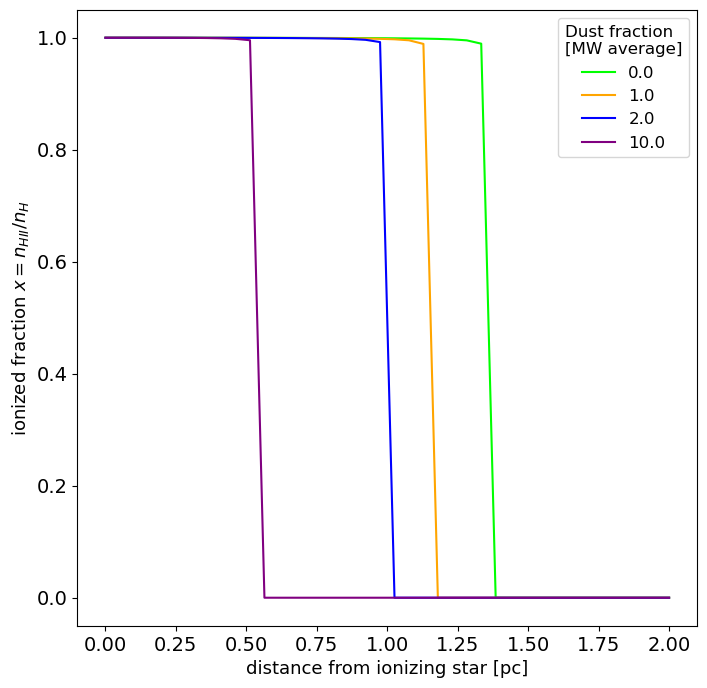

In [155]:
fig, ax = plt.subplots(figsize=(8,8))

# How much dust is present in the nebula compared to galactic average 
dust_H_fraction = [0,1,2,10]
colors = ['lime','orange','blue','purple']

r_max = 2 * parsec  # Maximum radius to consider (cm)
for csi,col in zip(dust_H_fraction,colors):

    # Solve for x(r)
    
    r_array, x_array = solve_ionization_profile(r_max)
    ax.plot(r_array/parsec,x_array,label=f"{csi:.1f}",c=col)

ax.set_xlabel("distance from ionizing star [pc]",fontsize=13)
ax.set_ylabel("ionized fraction $x = n_{HII}/n_H$",fontsize=13)

ax.legend(loc='upper right',title = "Dust fraction\n[MW average]",fontsize=12,title_fontsize=12) # bbox_to_anchor=(0.8, 1)
ax.tick_params(axis='both', which='major', labelsize=14)  # Increase major ticks

plt.show()



# Radiative transfer equation

The radiative transfer equation for optically thin sphere (with no diffusion involved) gives:

$$dI_\lambda = -I_\lambda\,\alpha_\lambda ds + j_\lambda ds$$

where the specific emissivity is a function of the ionized fraction (that we will assume 1 inside all nebula), the proton number density and the temperature:

$$j_\lambda = x^2 \,n_H^2 \alpha_\lambda(T)\frac{hc}{\lambda}$$

$\alpha_\lambda(T)$ is part of the effective recombination coefficient, and for $T\sim 10^4 \ \text{K}$, typical for an HII region, is $10^{-13} \mathrm{cm^3 \ s^{-1}}$ for $H\alpha$ line. The emissivity $j$ is measured in $\mathrm{erg \ s^{-1} cm^{-2} \ sterad^{-1}}$. 
Moreover we need to convert sterad to $\text{arcsec}^2$: $1 \ \text{sterad} = (206265 \text{arcsec})^2$.

For an optically thin spherical cloud (case B recombination: the cloud is optically thick only for Lyman continuum photons, but optically thin for all other transitions, like H$\alpha$ or H$\beta$):

$$SB(r) = j \, ds = 2 \int_{\arcsin(r/R_\text{cloud})}^{\pi/2} j \, R_\text{cloud}\sin(\theta)d\theta = 2 j\, R_\text{cloud} \sqrt{1-(\tfrac{r}{R_\text{cloud}})^2}$$

where $r = R_{cloud} \sin(\theta)$ is the projected radius in the sky. 

However, if we consider dust absorption the full radiative transfer equation must be considered:

$$I_\lambda(\tau_\lambda) = I_{0,\lambda}e^{-\tau_\lambda} + \int_0^{\tau_\nu} e^{-(\tau_\nu-\tau_\nu')}S_\lambda(\tau_\lambda')d\tau'_\lambda$$

where the dust optical depth is:

$$\tau_\lambda = \int \alpha_\lambda ds = \int n_\text{dust}\sigma_\lambda ds = \sigma_\lambda \frac{n_\text{dust}}{n_H} \int n_{_H}ds = \sigma_{\lambda,_H} \, n_{_H} \, s = \sigma_{\lambda,_H}\, N_H$$

with $\sigma_{\lambda,H}$ is the cross section per unit hydrogen atom.

$$I_\lambda(s) = \sigma_{\lambda,H} \, n_H \int_0^{s} e^{-\sigma_{\lambda,H}\,n_H\,(s-s')} \frac{j_\lambda}{\sigma_{\lambda,_H}n_{_H}} ds' = \frac{j_\lambda}{\sigma_{\lambda,_H}\,n_{_H}}\left(1-e^{-\sigma_{\lambda,_H}\,n_{_H}\, s}    \right)$$


**Balmer decrements**

Dust absorption depends strongly on the wavelength. 

$$\frac{I(H\alpha)}{I(H\beta)}(s) = \frac{j_\alpha}{j_\beta} \cdot \frac{\sigma_{\beta,H}}{\sigma_{\alpha,H}} \cdot \frac{ \left(1 - e^{-\xi\,\sigma_{\alpha,H}\,n_H\,s}\right)}{\left(1 - e^{-\xi\,\sigma_{\beta,H} \, n_H \, s}\right)}$$

The ratio of the emissivities depends only on the temperature, that we can assume $T\sim 10^4$ K. It is 2.86.

In [9]:
### === Surface Brightness Radial Model === ### 

# Physical Constants
wavelength_Ha = 656.281e-7    # Hα line (cm)
wavelength_Hb = 486.1e-7      # Hβ line (cm)
h = 6.62607015e-27            # Planck's constant (erg·s)
c = 3.0e10                    # Speed of light (cm/s)
parsec = 3.086e18             # cm
T = 1e4                       # Electron temperature [K]
alpha_B = 2.59e-13 * (T / 1e4)**(-0.7)  # Case B total recombination coefficient (cm³/s)

# Cloud Parameters
distance = 714 * parsec
n_H = 1e2                     # Hydrogen number density [cm⁻³]
x = 0.1                         # Ionized fraction
R_inner_void = 1.5 / 3437.75 * distance  # Inner void radius
R_cloud = 5 / 3437.75 * distance         # Strömgren radius

# Emissivity
j_Ha = x**2 * n_H**2 * alpha_B * h * c / wavelength_Ha / 206265**2
j_Hb = j_Ha / 2.86

# Surface Brightness Model Function
from scipy.integrate import quad
import numpy as np

def SB_model(r, j, csi, sigma_dust, R_cloud, R_inner_void, n_H):
    s = np.where(
        r < R_inner_void, 
        2 * R_cloud * np.sqrt(np.clip(1 - (r / R_cloud) ** 2, 0, None)) 
        - 2 * R_inner_void * np.sqrt(np.clip(1 - (r / R_inner_void) ** 2, 0, None)),  
        2 * R_cloud * np.sqrt(np.clip(1 - (r / R_cloud) ** 2, 0, None))
    )
    return j / (csi * sigma_dust * n_H) * (1 - np.exp(-csi * sigma_dust * n_H * s))


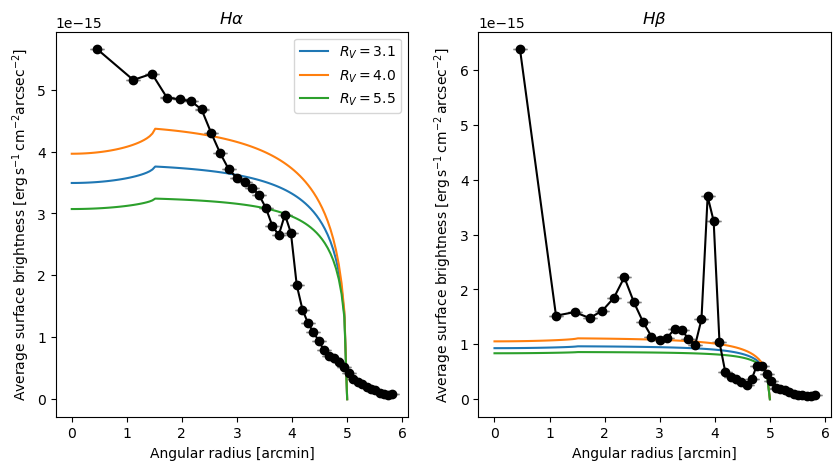

In [10]:
### === Plot Profiles === ###
import matplotlib.pyplot as plt

angular_size_pixel_TOBI_arcmin = 0.44 / 60  # arcmin per pixel

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Hα Surface Brightness Profile
ax[0].set(
    title="$H\\alpha$", 
    xlabel="Angular radius [arcmin]", 
    ylabel="Average surface brightness $[\\mathrm{erg\\, s^{-1}\\, cm^{-2} arcsec^{-2}}]$"
)
I_Ha = [ph[0] for ph in average_surface_brightness_Ha_annulus]
err_Ha = [ph[1] for ph in average_surface_brightness_Ha_annulus]
ax[0].errorbar(theta_r, I_Ha, yerr=err_Ha, fmt='o', color='black', ecolor='grey', capsize=5, linestyle='-')

# Hβ Surface Brightness Profile
ax[1].set(
    title="$H\\beta$", 
    xlabel="Angular radius [arcmin]", 
    ylabel="Average surface brightness $[\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, arcsec^{-2}}]$"
)
I_Hb = [ph[0] for ph in average_surface_brightness_Hb_annulus]
err_Hb = [ph[1] for ph in average_surface_brightness_Hb_annulus]
ax[1].errorbar(theta_r, I_Hb, yerr=err_Hb, fmt='o', color='black', ecolor='grey', capsize=5, linestyle='-')

# Compute Theoretical Surface Brightness
r_grid = np.linspace(0, R_cloud, 100)
theta_r_grid = r_grid / distance * 3437.75

# Ensure R_V is iterable
if not isinstance(R_V, (list, np.ndarray)):
    R_V = [R_V]

# Iterate over extinction models
csi = 10
for rv in R_V:
    sigma_dust_H_Ha = dust_extinction[rv]['extinction_H_curve'](wavelength_Ha * 1e4)
    sigma_dust_H_Hb = dust_extinction[rv]['extinction_H_curve'](wavelength_Hb * 1e4)
    
    ax[0].plot(theta_r_grid, SB_model(r_grid, j_Ha, csi, sigma_dust_H_Ha, R_cloud, R_inner_void, n_H), 
               label=rf"$R_V = {rv}$")

    ax[1].plot(theta_r_grid, SB_model(r_grid, j_Hb, csi, sigma_dust_H_Hb, R_cloud, R_inner_void, n_H), 
            label=rf"$R_V = {rv}$")

ax[0].legend()
plt.show()